# Virchow deployment in Azure ML Studio

This sample notebook shows how to deploy a Virchow model (eg. Virchow2G-Mini) in azure ML studio. Given a set of input tiles of size 224x224 pixels, extracted from a pathology whole slide image, the model outputs an embedding for each tile. These embeddings can be used to train models for downstream tasks.

## 1. Authentication

In [69]:
from azure.ai.ml import MLClient
from azure.identity import (
    DefaultAzureCredential,
    AzureCliCredential,
    InteractiveBrowserCredential,
    ClientSecretCredential,
)
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
)

In [2]:
credential = AzureCliCredential()  # Choose your authentication strategy.

## 2. Select the model

In [ ]:
# The models are available in the AzureML system registry, "azureml"
registry_ml_client = MLClient(
    credential,
    registry_name="azureml",
)
model = registry_ml_client.models.get(name="Virchow2G-Mini", label="latest")
ml_client = MLClient.from_config(credential)

## 3. Deploy the model to an online endpoint for real time inference

In [6]:
import random
import string

endpoint_name = "virchow2g-mini-demo"

# Creating a unique endpoint name by including a random suffix
allowed_chars = string.ascii_lowercase + string.digits
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))
endpoint_name = f"{endpoint_name}-{endpoint_suffix}"

print(f"Endpoint name: {endpoint_name}")

Endpoint name: virchow2g-mini-demo-iwqq2


In [7]:
endpoint = ManagedOnlineEndpoint(name=endpoint_name)
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [10]:
from azure.ai.ml.entities import OnlineRequestSettings

deployment_name = "virchow2g-mini-demo"
deployment_package = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model,
    instance_type="Standard_DS3_v2",  # Use a GPU instance type like Standard_NC6s_v3 for fast inference
    instance_count=1,
    request_settings=OnlineRequestSettings(request_timeout_ms=90000),
    app_insights_enabled=True,
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(deployment_package).result()

## Test the model

The model processes 224 x 224 pixel inputs. In practice, one typically wishes to process whole slide pathology images that can be split into thousands of such tiles. These tiles are then fed batch-wise through the model to get an embedding per tile.

### Requirements

Tiles must be 224 by 224 pixels in size but can be any magnification (the model is trained on 40x through 5x magnifications).

### Foreground detection

Since a large fraction of a whole slide image is the glass slide background, foreground detection is done to select only the tiles that contain tissue. One common approach is to use an Otsu filter on HSV values. You could use a popular public academic framework like CLAM (https://github.com/mahmoodlab/CLAM).

### Tile-level example

Here, we will download a crop of a pathology image and split it into two tiles.

In [29]:
import urllib.request

image_url = 'https://webpath.med.utah.edu/jpeg3/SKIN117.jpg'
image_path = 'SKIN117.jpg'

urllib.request.urlretrieve(image_url, image_path)
print(f"Image downloaded to {image_path}")

Image downloaded to SKIN117.jpg


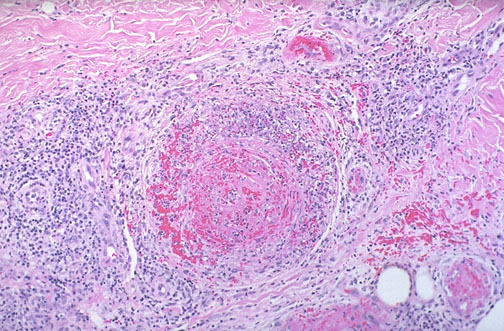

In [31]:
from PIL import Image

im = Image.open(image_path)
display(im)

[(224, 224, 3), (224, 224, 3), (107, 224, 3), (107, 224, 3), (0, 224, 3), (0, 224, 3)]
We're only keeping the full tiles (the first two crops)


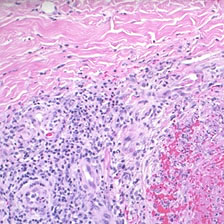

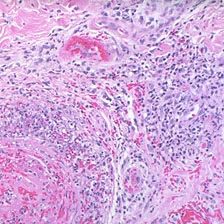

In [66]:
# Split into tiles

import numpy as np

im_np = np.array(im)

# Define the grid limits and spacing
x_max, y_max = im_np.shape[0], im_np.shape[1]
tile_size = 224

# Generate coordinates
x = np.arange(0, x_max, spacing)
y = np.arange(0, y_max, spacing)
xx, yy = np.meshgrid(x, y)
grid_points = np.stack([yy.ravel(), xx.ravel()], axis=-1)
crops = [im_np[r:r+tile_size, c:c+tile_size] for r, c in grid_points]

print([c.shape for c in crops])
print("We're only keeping the full tiles (the first two crops)")

display(Image.fromarray(crops[0]))
display(Image.fromarray(crops[1]))

In [ ]:
# Images are passed in with byte64 encoding

import base64
import io
import PIL


def image_to_base64(img: PIL.Image.Image, format: str = 'tiff') -> str:
    """
    Convert image into Base64 encoded string.

    :param img: image object
    :type img: PIL.Image.Image
    :param format: image format
    :type format: str
    :return: base64 encoded string
    :rtype: str
    """
    buffered = io.BytesIO()
    img.save(buffered, format=format)
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

In [47]:
# Craft the payload
data = {
    "input_data": {
        "columns": ["image"],
        "index": [0, 1],
        "data": [
            image_to_base64(Image.fromarray(crops[0])),
            image_to_base64(Image.fromarray(crops[1])),
        ],
    },
    "params": {'device_type': 'cpu'},    # Change to 'cuda' if using GPU
}

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(data, request_file)

In [48]:
# Score the sample_score.json file using the online endpoint with the azureml endpoint invoke method
response = ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
print(f"raw response: {response}\n")

raw response: [{"output": [-0.7314453125, -0.388671875, 0.219970703125, 0.481201171875, -0.52685546875, -0.81689453125, 0.305419921875, -0.86376953125, -0.0193634033203125, -0.2452392578125, 0.6640625, -0.32958984375, 0.56494140625, -0.14306640625, -0.2255859375, 0.27392578125, -0.031280517578125, -0.102294921875, -0.08148193359375, 0.48388671875, -0.07415771484375, -0.061187744140625, 0.7529296875, -0.413818359375, 0.11505126953125, -0.61181640625, -0.5048828125, -0.368408203125, 0.1446533203125, -0.495849609375, -0.055206298828125, 0.272216796875, 0.08056640625, -0.07073974609375, -0.3310546875, 0.87841796875, -0.35009765625, 0.18603515625, -0.390869140625, 0.38623046875, 0.276123046875, 0.1773681640625, -0.466796875, 0.252685546875, -0.14892578125, 0.0081939697265625, 0.7431640625, -0.24365234375, -0.28466796875, -0.23779296875, -0.279052734375, -0.30908203125, -0.69873046875, -0.3203125, -0.2330322265625, -0.356201171875, -0.15966796875, 0.63232421875, 0.12457275390625, -0.22973632

In [68]:
# Convert the response into a 'minibatch' array, corresponding to the input minibatch of two tiles.
response_list = json.loads(response)
output_batch = np.array([r['output'] for r in response_list])
print(f'Output shape is {output_batch.shape}')

Output shape is (2, 768)


# 5. Clean up resources - delete the online endpoint

Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [70]:
ml_client.online_endpoints.begin_delete(name=endpoint_name).wait()

..............................................................................